# Proyecto de Clasificación de Noticias Falsas en Español

Este notebook contiene la implementación de un modelo de Machine Learning para clasificar noticias como verdaderas o falsas. Se utilizan técnicas de procesamiento de lenguaje natural para analizar el contenido de los títulos y descripciones de las noticias.

*Estudiante 1:* Rodrigo Paz Londoño.
*Estudiante 2:*Juan José Murillo Aristizabal.
*Estudiante 3:* Manolo Hernandez Rojas.

## Instalación de Dependencias

Se instalan las bibliotecas necesarias para el procesamiento de texto y el modelado de Machine Learning.

In [2]:
!pip install seaborn
!pip install spacy
!pip install scikit-learn
!pip install nltk
!python -m spacy download es_core_news_sm
!python -m spacy download es_core_news_sm
!pip install joblib
!pip install tensorflow
!pip install keras
!pip install scikeras
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install gensim
!pip install wordcloud
!pip install sklearn
!pip install visualkeras
!pip install --upgrade scikeras scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 77.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.7.0/es_core_news_sm-3.7.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │

## Importación de Bibliotecas

Se importan las bibliotecas necesarias para el análisis de datos, procesamiento de texto y modelado.

In [3]:
import pandas as pd
import seaborn as sns
import re, unicodedata
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import  confusion_matrix
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from joblib import dump, load
import numpy as np
from sklearn.neural_network import MLPClassifier

## Carga de Datos

Se carga el dataset con noticias en español desde un archivo CSV. Aseguramos que la columna de fecha esté en el formato adecuado.

In [5]:

# Uso de la libreria pandas para la lectura de archivos
data = pd.read_csv('fake_news_spanish.csv', sep=';', encoding='utf-8')
# Asignación a una nueva variable de los datos leidos
data_t = data


data_t["Fecha"] = pd.to_datetime(data_t["Fecha"], format="%d/%m/%Y")

print(data_t.head())


   ID  Label                                             Titulo  \
0  ID      1  'The Guardian' va con Sánchez: 'Europa necesit...   
1  ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  ID      1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4  ID      0  Puigdemont: 'No sería ninguna tragedia una rep...   

                                         Descripcion      Fecha  
0  El diario británico publicó este pasado jueves... 2023-06-02  
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ... 2023-10-01  
2  El valencianismo convoca en Castelló su fiesta... 2022-04-25  
3  En política, igual que hay que negociar con lo... 2022-01-03  
4  En una entrevista en El Punt Avui, el líder de... 2018-03-09  


## Exploración de Datos

Se examina la estructura de los datos para entender su composición y detectar valores nulos o inconsistencias.

In [6]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           57063 non-null  object        
 1   Label        57063 non-null  int64         
 2   Titulo       57047 non-null  object        
 3   Descripcion  57063 non-null  object        
 4   Fecha        57063 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.2+ MB


## Análisis de Correlación entre Fecha y Etiqueta

Convertimos la fecha en un valor numérico y analizamos su correlación con la etiqueta de veracidad de la noticia.

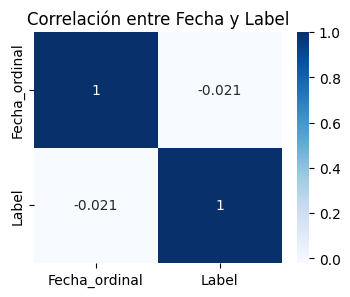

In [7]:

# Convertimos la fecha a ordinal
data_t['Fecha_ordinal'] = data_t['Fecha'].apply(lambda x: x.toordinal())

# Calculamos la matriz de correlación con Label
corr_matrix = data_t[['Fecha_ordinal', 'Label']].corr()

# Graficar la matriz de correlación
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlación entre Fecha y Label')
plt.show()

Se puede decir que la fecha no tiene una correlación relevante con la variable de interés "Label", por ello, se decide que no se incluirá en el modelo.

##Análisis de Longitud de Textos en Títulos y Descripciones

En esta sección, se realiza un análisis de la estructura de los textos en las noticias. Se calculan métricas clave sobre los títulos y descripciones para comprender mejor la distribución de palabras y su impacto en el modelo.

*   Relleno de valores nulos: Se reemplazan los valores faltantes en la columna 'Titulo' con una cadena vacía para evitar errores en el procesamiento.
*   Conteo de caracteres: Se calcula la longitud total de cada descripción y título.
*  Palabra más larga y más corta: Se extrae la longitud de la palabra más larga y más corta en cada descripción y título, lo que permite analizar la complejidad del vocabulario.

Este análisis proporciona información útil para entender la variabilidad en la longitud del texto, lo que puede influir en el rendimiento del modelo de clasificació




In [8]:
textos = data_t.copy()
textos['Titulo'] = textos['Titulo'].fillna("")
textos['Conteo Descripcion'] = [len(x) for x in textos['Descripcion']]
textos['Conteo Titulo'] = [len(x) for x in textos['Titulo']]
textos['Max Descripcion'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Descripcion']]
textos['Max Titulo'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Titulo']]
textos['Min Descripcion'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Descripcion']]
textos['Min Titulo'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Titulo']]

## Preprocesamiento de Texto

Se aplica procesamiento de texto utilizando spaCy para eliminar stopwords, realizar lematización y normalizar el texto, de igual forma se crean funciones con el fin de eliminar caracteres no ASCII, convertir todo a minuscula, remover puntuación, elminar palabras vacías.

In [9]:

nltk.download('stopwords')
def remove_non_ascii(words):
    """
    Elimina caracteres no ASCII de una lista de palabras tokenizadas.
    Nota: Esto removerá acentos y caracteres especiales del español.
    """
    new_words = []
    for word in words:
        if word is not None:
            new_word = unicodedata.normalize('NFKD', word)\
                      .encode('ascii', 'ignore')\
                      .decode('utf-8', 'ignore')
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """
    Convierte todos los caracteres a minúsculas a partir de una lista de palabras tokenizadas.
    """
    return [word.lower() for word in words if word is not None]

def remove_punctuation(words):
    """
    Elimina la puntuación de una lista de palabras tokenizadas.
    """
    new_words = []
    for word in words:
        if word is not None:
            # Se eliminan todos los caracteres que no sean letras, dígitos o espacios.
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """
    Elimina las palabras vacías (stopwords) de una lista de palabras tokenizadas usando
    la lista de stopwords en español de NLTK.
    """
    stop_words = set(stopwords.words('spanish'))
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    """
    Aplica una serie de transformaciones a una lista de palabras tokenizadas:
      - Convertir a minúsculas.
      - Eliminar puntuación.
      - Eliminar caracteres no ASCII (opcional, cuidado con acentos).
      - Eliminar palabras vacías.
    """
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# Cargar el modelo de español
nlp = spacy.load("es_core_news_sm")

# Suponiendo que data_t es tu DataFrame y tiene la columna 'Descripcion'
# Definimos una función de preprocesamiento con spaCy
def preprocess_text(text):
    # Verificar que el texto no sea NaN
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    # Procesamos cada token:
    # - Convertimos a minúscula
    # - Extraemos el lema
    # - Eliminamos tokens de puntuación y stopwords
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-'
    ]
    return " ".join(tokens)

# Aplicamos la función a la columna 'Descripcion'
data_t['Descripcion_processed'] = data_t['Descripcion'].apply(preprocess_text)
data_t['Titulo_processed'] = data_t['Titulo'].apply(preprocess_text)


# Mostramos algunos resultados
print(data_t[['Descripcion', 'Descripcion_processed', 'Titulo','Titulo_processed']].head())


KeyboardInterrupt: 

In [ ]:
# Función para tokenizar el texto procesado (dividir en tokens)
def tokenize_text(text):
    return text.split()

# Aplicamos la tokenización sobre el texto preprocesado
data_t['Tokens_Descripcion'] = data_t['Descripcion_processed'].apply(tokenize_text)
data_t['Tokens_Titulo'] = data_t['Titulo_processed'].apply(tokenize_text)


# Mostramos algunos resultados
print(data_t[['Descripcion','Tokens_Descripcion', 'Titulo','Tokens_Titulo']].head())

Elimina los valores nulos de los tokens

In [ ]:
data_t['Tokens_Descripcion'].dropna()
data_t['Tokens_Titulo'].dropna()

Revisar los datos

In [ ]:
data_t['Tokens_Descripcion'].info()
data_t['Tokens_Titulo'].info()

Se aplica el procesamiento

In [ ]:
data_t['Words_Descripcion']=data_t['Tokens_Descripcion'].apply(preprocessing)
data_t['Words_Titulo']=data_t['Tokens_Titulo'].apply(preprocessing)

data_t

# Entrenamiento de cada uno de los Modelos



*   Árbol de Decisión
*   Regresión Logística
*   Red Neuronal


## Entrenamiento del árbol de decisión

Se crea un pipeline para procesar el texto y entrenar un modelo de árbol de decisión para la clasificación de noticias.

In [ ]:
# Convertir listas en cadenas de texto para que TfidfVectorizer pueda procesarlas
data_t["Words_Titulo"] = data_t["Words_Titulo"].apply(lambda x: " ".join(x))
data_t["Words_Descripcion"] = data_t["Words_Descripcion"].apply(lambda x: " ".join(x))
print(data_t[['Words_Titulo', 'Words_Descripcion']].head())
# Creamos un nuevo DataFrame con las columnas transformadas
df_text = pd.DataFrame({
    "Words_Titulo": data_t["Words_Titulo"],
    "Words_Descripcion": data_t["Words_Descripcion"],
    "Label": data_t["Label"]
})



# Separar variables predictoras y variable objetivo
X = data_t[['Words_Titulo', 'Words_Descripcion']]
y = data_t['Label']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Pipeline de preprocesamiento que incluye las características de texto
preprocessor = ColumnTransformer([
    ('title_tfidf', TfidfVectorizer(), 'Words_Titulo'),
    ('desc_tfidf', TfidfVectorizer(), 'Words_Descripcion')
])

# Crear el pipeline con un Árbol de Decisión
pipeline = Pipeline([
    ('features', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=69))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)





#### Evaluación del Modelo

Se evalúa el desempeño del modelo en el conjunto de prueba utilizando métricas como precisión, recall y matriz de confusión.

In [ ]:
# Realizar las predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la matriz de confusión
# En la matriz, se asume la siguiente estructura:
# [[TN, FP],
#  [FN, TP]]
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Calcular las métricas
# Exactitud (Accuracy): (VP + VN) / Total
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Error: (FP + FN) / Total
error_rate = (FP + FN) / (TP + TN + FP + FN)

# Precisión: VP / (VP + FP)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Sensibilidad o Recall: VP / (VP + FN)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Especificidad: VN / (VN + FP)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

# F1-Score: 2 * (precision * recall) / (precision + recall)
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Imprimir las métricas
print("Métricas del modelo:")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Error: {error_rate:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"Especificidad: {specificity:.2f}")
print(f"F1-Score: {f1_score:.2f}")


In [ ]:
# Obtener probabilidades de predicción
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva AUC-ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Árbol de Decisión')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:

importancia = pipeline.named_steps['classifier'].feature_importances_

# Obtener nombres de las características desde TF-IDF (título y descripción)
vectorizer_title = pipeline.named_steps['features'].named_transformers_['title_tfidf']
vectorizer_desc = pipeline.named_steps['features'].named_transformers_['desc_tfidf']

# Extraer nombres de las palabras de cada vectorizador
feature_names_title = vectorizer_title.get_feature_names_out()
feature_names_desc = vectorizer_desc.get_feature_names_out()

# Combinar los nombres de las características en un solo array
feature_names = np.concatenate([feature_names_title, feature_names_desc])

# Verificar que la cantidad de nombres y coeficientes coincida
assert len(feature_names) == len(importancia), f"Dimensiones no coinciden: {len(feature_names)} != {len(importancia)}"

# Crear un DataFrame con la importancia de cada palabra
importancia_atributo = pd.DataFrame({"Atributo": feature_names, "Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)

# Mostrar las 15 palabras más importantes
print("🔹 Palabras más influyentes en la predicción:")
print(importancia_atributo.head(50))

plt.figure(figsize=(10, 6))
plt.barh(importancia_atributo["Atributo"][:50], importancia_atributo["Importancia"][:50], color='blue')
plt.xlabel("Importancia")
plt.ylabel("Palabra")
plt.title("Palabras más influyentes en la clasificación - Árbol de Decisión")
plt.gca().invert_yaxis()  # Invertir el eje para que la palabra más influyente aparezca arriba
plt.show()


In [ ]:
filename = "model_decision_tree.joblib"
dump(pipeline, filename)
pipeline_loaded = load(filename)

In [ ]:

# Cargar el modelo previamente guardado
filename = "model_decision_tree.joblib"
pipeline_loaded = load(filename)

# Cargar los datos de prueba
test_data = pd.read_csv('fake_news_test.csv', sep=';', encoding='utf-8')

# Cargar el modelo de español
nlp = spacy.load("es_core_news_sm")

# Suponiendo que data_t es tu DataFrame y tiene la columna 'Descripcion'
# Definimos una función de preprocesamiento con spaCy
def preprocess_text(text):
    # Verificar que el texto no sea NaN
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    # Procesamos cada token:
    # - Convertimos a minúscula
    # - Extraemos el lema
    # - Eliminamos tokens de puntuación y stopwords
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-'
    ]
    return " ".join(tokens)

# Aplicamos la función a la columna 'Descripcion'
test_data['Descripcion_processed'] = test_data['Descripcion'].apply(preprocess_text)
test_data['Titulo_processed'] = test_data['Titulo'].apply(preprocess_text)


# Mostramos algunos resultados
print(test_data[['Descripcion', 'Descripcion_processed', 'Titulo','Titulo_processed']].head())


In [ ]:
# Función para tokenizar el texto procesado (dividir en tokens)
def tokenize_text(text):
    return text.split()

# Aplicamos la tokenización sobre el texto preprocesado
test_data['Tokens_Descripcion'] = test_data['Descripcion_processed'].apply(tokenize_text)
test_data['Tokens_Titulo'] = test_data['Titulo_processed'].apply(tokenize_text)


# Mostramos algunos resultados
print(test_data[['Descripcion','Tokens_Descripcion', 'Titulo','Tokens_Titulo']].head())

test_data['Tokens_Descripcion'].dropna()
test_data['Tokens_Titulo'].dropna()

In [ ]:
test_data['Words_Descripcion']=test_data['Tokens_Descripcion'].apply(preprocessing)
test_data['Words_Titulo']=test_data['Tokens_Titulo'].apply(preprocessing)

test_data


In [ ]:
# Verificar que las columnas correctas existen en los datos de prueba
if 'Words_Titulo' in test_data.columns and 'Words_Descripcion' in test_data.columns:
    # Convertir listas en cadenas de texto si es necesario
    test_data["Words_Titulo"] = test_data["Words_Titulo"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
    test_data["Words_Descripcion"] = test_data["Words_Descripcion"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

    # Realizar predicciones
    predictions = pipeline_loaded.predict(test_data[['Words_Titulo', 'Words_Descripcion']])

    # Guardar los resultados en un nuevo CSV
    test_data["Label"] = predictions

    #Borrar las columnas de texto procesado
    test_data.drop(columns=['Descripcion_processed', 'Titulo_processed', 'Tokens_Descripcion', 'Tokens_Titulo','Words_Titulo','Words_Descripcion'], inplace=True)
    test_data.to_csv("fake_news_predictions_decision_tree.csv", index=False)

    print("Predicciones guardadas en 'fake_news_predictions_decision_tree.csv'")
else:
    print("Error: Las columnas 'Words_Titulo' y 'Words_Descripcion' no están en el archivo de prueba.")



## Entrenamiento de la regresión Logística

Se crea un pipeline para procesar el texto y entrenar un modelo de regresión logística para la clasificación de noticias.

In [ ]:


# Separar variables predictoras y variable objetivo
X = data_t[['Words_Titulo', 'Words_Descripcion']]
y = data_t['Label']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Pipeline de preprocesamiento que incluye las características de texto
preprocessor = ColumnTransformer([
    ('title_tfidf', TfidfVectorizer(), 'Words_Titulo'),
    ('desc_tfidf', TfidfVectorizer(), 'Words_Descripcion')
])

# Pipeline completo con regresión logística
pipeline = Pipeline([
    ('features', preprocessor),
    ('classifier', LogisticRegression())
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)



#### Evaluación del Modelo

Se evalúa el desempeño del modelo en el conjunto de prueba utilizando métricas como precisión, recall y matriz de confusión.

In [ ]:

# Realizar las predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la matriz de confusión
# En la matriz, se asume la siguiente estructura:
# [[TN, FP],
#  [FN, TP]]
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Calcular las métricas
# Exactitud (Accuracy): (VP + VN) / Total
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Error: (FP + FN) / Total
error_rate = (FP + FN) / (TP + TN + FP + FN)

# Precisión: VP / (VP + FP)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Sensibilidad o Recall: VP / (VP + FN)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Especificidad: VN / (VN + FP)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

# F1-Score: 2 * (precision * recall) / (precision + recall)
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Imprimir las métricas
print("Métricas del modelo:")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Error: {error_rate:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"Especificidad: {specificity:.2f}")
print(f"F1-Score: {f1_score:.2f}")


In [ ]:
# Obtener probabilidades de predicción
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva AUC-ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Obtener las transformaciones de ColumnTransformer
vectorizer_titulo = pipeline.named_steps['features'].named_transformers_['title_tfidf']
vectorizer_desc = pipeline.named_steps['features'].named_transformers_['desc_tfidf']

# Obtener los nombres de las palabras procesadas en cada vectorizador
feature_names_titulo = vectorizer_titulo.get_feature_names_out()
feature_names_desc = vectorizer_desc.get_feature_names_out()

# Combinar todas las palabras
feature_names = np.concatenate([feature_names_titulo, feature_names_desc])

# Obtener los coeficientes del modelo de regresión logística
coefs = pipeline.named_steps['classifier'].coef_[0]

# Verificar que las longitudes coincidan
assert len(feature_names) == len(coefs), f"Dimensiones no coinciden: {len(feature_names)} != {len(coefs)}"

# Crear un DataFrame con palabras y sus coeficientes
word_importance = pd.DataFrame({'Palabra': feature_names, 'Coeficiente': coefs})

# Ordenar palabras más asociadas con noticias falsas (coeficiente más negativo)
top_false_words = word_importance.sort_values(by='Coeficiente', ascending=True).head(50)

# Graficar las palabras más asociadas con noticias falsas
plt.figure(figsize=(10, 6))
plt.barh(top_false_words['Palabra'], top_false_words['Coeficiente'], color='red')
plt.xlabel('Coeficiente')
plt.ylabel('Palabra')
plt.title('Palabras más asociadas con noticias falsas')
plt.gca().invert_yaxis()  # Invertir eje para mostrar la palabra más relevante arriba
plt.show()


In [ ]:
filename = "model_logistic_regression.joblib"
dump(pipeline, filename)
pipeline_loaded = load(filename)

In [ ]:

# Cargar el modelo previamente guardado
filename = "model_logistic_regression.joblib"
pipeline_loaded = load(filename)

# Cargar los datos de prueba
test_data = pd.read_csv('fake_news_test.csv', sep=';', encoding='utf-8')

# Cargar el modelo de español
nlp = spacy.load("es_core_news_sm")

# Suponiendo que data_t es tu DataFrame y tiene la columna 'Descripcion'
# Definimos una función de preprocesamiento con spaCy
def preprocess_text(text):
    # Verificar que el texto no sea NaN
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    # Procesamos cada token:
    # - Convertimos a minúscula
    # - Extraemos el lema
    # - Eliminamos tokens de puntuación y stopwords
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-'
    ]
    return " ".join(tokens)

# Aplicamos la función a la columna 'Descripcion'
test_data['Descripcion_processed'] = test_data['Descripcion'].apply(preprocess_text)
test_data['Titulo_processed'] = test_data['Titulo'].apply(preprocess_text)


# Mostramos algunos resultados
print(test_data[['Descripcion', 'Descripcion_processed', 'Titulo','Titulo_processed']].head())


In [ ]:
# Función para tokenizar el texto procesado (dividir en tokens)
def tokenize_text(text):
    return text.split()

# Aplicamos la tokenización sobre el texto preprocesado
test_data['Tokens_Descripcion'] = test_data['Descripcion_processed'].apply(tokenize_text)
test_data['Tokens_Titulo'] = test_data['Titulo_processed'].apply(tokenize_text)


# Mostramos algunos resultados
print(test_data[['Descripcion','Tokens_Descripcion', 'Titulo','Tokens_Titulo']].head())

test_data['Tokens_Descripcion'].dropna()
test_data['Tokens_Titulo'].dropna()

In [ ]:
test_data['Words_Descripcion']=test_data['Tokens_Descripcion'].apply(preprocessing)
test_data['Words_Titulo']=test_data['Tokens_Titulo'].apply(preprocessing)

test_data


In [ ]:
# Verificar que las columnas correctas existen en los datos de prueba
if 'Words_Titulo' in test_data.columns and 'Words_Descripcion' in test_data.columns:
    # Convertir listas en cadenas de texto si es necesario
    test_data["Words_Titulo"] = test_data["Words_Titulo"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
    test_data["Words_Descripcion"] = test_data["Words_Descripcion"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

    # Realizar predicciones
    predictions = pipeline_loaded.predict(test_data[['Words_Titulo', 'Words_Descripcion']])

    # Guardar los resultados en un nuevo CSV
    test_data["Label"] = predictions

    #Borrar las columnas de texto procesado
    test_data.drop(columns=['Descripcion_processed', 'Titulo_processed', 'Tokens_Descripcion', 'Tokens_Titulo','Words_Titulo','Words_Descripcion'], inplace=True)
    test_data.to_csv("fake_news_predictions_logistic_regression.csv", index=False)

    print("Predicciones guardadas en 'fake_news_predictions_logistic_regression.csv'")
else:
    print("Error: Las columnas 'Words_Titulo' y 'Words_Descripcion' no están en el archivo de prueba.")



## Entrenamiento de la red neuronal

Se crea un pipeline para procesar el texto y entrenar un modelo de red neuronal para la clasificación de noticias.

In [ ]:
X = df_text[['Words_Titulo', 'Words_Descripcion']]
y = df_text['Label']
dataset=df_text.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

In [ ]:
preprocessor = ColumnTransformer([
    ('title_tfidf', TfidfVectorizer(), 'Words_Titulo'),
    ('desc_tfidf', TfidfVectorizer(), 'Words_Descripcion')
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(50,), random_state=42, max_iter=1500))
])
pipeline.fit(X_train, y_train)


#### Evaluación del Modelo

Se evalúa el desempeño del modelo en el conjunto de prueba utilizando métricas como precisión, recall y matriz de confusión.

In [ ]:
# Realizar las predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la matriz de confusión
# En la matriz, se asume la siguiente estructura:
# [[TN, FP],
#  [FN, TP]]
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Calcular las métricas
# Exactitud (Accuracy): (VP + VN) / Total
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Error: (FP + FN) / Total
error_rate = (FP + FN) / (TP + TN + FP + FN)

# Precisión: VP / (VP + FP)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Sensibilidad o Recall: VP / (VP + FN)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Especificidad: VN / (VN + FP)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

# F1-Score: 2 * (precision * recall) / (precision + recall)
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Imprimir las métricas
print("Métricas del modelo:")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Error: {error_rate:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"Especificidad: {specificity:.2f}")
print(f"F1-Score: {f1_score:.2f}")



In [ ]:
# Obtener probabilidades de predicción
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva AUC-ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Red Neuronal')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# 1. Filtrar el conjunto de entrenamiento para quedarnos con las noticias falsas.
# Ajusta la condición según la codificación de tus etiquetas.
false_mask = y_train == 0
X_false = X_train[false_mask]

# 2. Transformar el subconjunto de noticias falsas usando el preprocesador del pipeline
X_false_transformed = pipeline.named_steps['preprocessor'].transform(X_false)

# 3. Sumar los valores TF-IDF de cada palabra (cada columna de la matriz transformada)
# La matriz es sparse, por lo que se suma a lo largo de los registros (axis=0)
tfidf_sum = X_false_transformed.sum(axis=0)
tfidf_sum_array = np.array(tfidf_sum).flatten()

# 4. Extraer los nombres de las palabras de cada vectorizador del ColumnTransformer
vectorizer_titulo = pipeline.named_steps['preprocessor'].named_transformers_['title_tfidf']
vectorizer_desc = pipeline.named_steps['preprocessor'].named_transformers_['desc_tfidf']

feature_names_titulo = vectorizer_titulo.get_feature_names_out()
feature_names_desc = vectorizer_desc.get_feature_names_out()

# 5. Combinar los nombres de las palabras en un solo arreglo
feature_names = np.concatenate([feature_names_titulo, feature_names_desc])

# 6. Verificar que el número de palabras coincida con la cantidad de columnas de la matriz TF-IDF
assert len(feature_names) == len(tfidf_sum_array), f"Dimensiones no coinciden: {len(feature_names)} != {len(tfidf_sum_array)}"

# 7. Crear un DataFrame que asocia cada palabra con la suma de su TF-IDF en las noticias falsas
word_importance = pd.DataFrame({'Palabra': feature_names, 'TFIDF_Suma': tfidf_sum_array})

# 8. Ordenar las palabras de mayor a menor según su suma TF-IDF y seleccionar las 50 principales
top_false_words = word_importance.sort_values(by='TFIDF_Suma', ascending=False).head(50)

# 9. Graficar las 50 palabras más representativas
plt.figure(figsize=(10, 6))
plt.barh(top_false_words['Palabra'], top_false_words['TFIDF_Suma'], color='red')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Palabra')
plt.title('Palabras más asociadas con noticias falsas')
plt.gca().invert_yaxis()  # Invertir eje para mostrar la palabra más relevante arriba
plt.show()

In [ ]:
filename = "model_neural_network.joblib"
dump(pipeline, filename)
pipeline_loaded = load(filename)

In [ ]:
# Cargar el modelo previamente guardado
filename = "model_neural_network.joblib"
pipeline_loaded = load(filename)

# Cargar los datos de prueba
test_data = pd.read_csv('fake_news_test.csv', sep=';', encoding='utf-8')

# Cargar el modelo de español
nlp = spacy.load("es_core_news_sm")

# Suponiendo que data_t es tu DataFrame y tiene la columna 'Descripcion'
# Definimos una función de preprocesamiento con spaCy
def preprocess_text(text):
    # Verificar que el texto no sea NaN
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    # Procesamos cada token:
    # - Convertimos a minúscula
    # - Extraemos el lema
    # - Eliminamos tokens de puntuación y stopwords
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-'
    ]
    return " ".join(tokens)

# Aplicamos la función a la columna 'Descripcion'
test_data['Descripcion_processed'] = test_data['Descripcion'].apply(preprocess_text)
test_data['Titulo_processed'] = test_data['Titulo'].apply(preprocess_text)


# Mostramos algunos resultados
print(test_data[['Descripcion', 'Descripcion_processed', 'Titulo','Titulo_processed']].head())

In [ ]:
# Función para tokenizar el texto procesado (dividir en tokens)
def tokenize_text(text):
    return text.split()

# Aplicamos la tokenización sobre el texto preprocesado
test_data['Tokens_Descripcion'] = test_data['Descripcion_processed'].apply(tokenize_text)
test_data['Tokens_Titulo'] = test_data['Titulo_processed'].apply(tokenize_text)


# Mostramos algunos resultados
print(test_data[['Descripcion','Tokens_Descripcion', 'Titulo','Tokens_Titulo']].head())

test_data['Tokens_Descripcion'].dropna()
test_data['Tokens_Titulo'].dropna()

In [ ]:
test_data['Words_Descripcion']=test_data['Tokens_Descripcion'].apply(preprocessing)
test_data['Words_Titulo']=test_data['Tokens_Titulo'].apply(preprocessing)

test_data

In [ ]:
# Verificar que las columnas correctas existen en los datos de prueba
if 'Words_Titulo' in test_data.columns and 'Words_Descripcion' in test_data.columns:
    # Convertir listas en cadenas de texto si es necesario
    test_data["Words_Titulo"] = test_data["Words_Titulo"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
    test_data["Words_Descripcion"] = test_data["Words_Descripcion"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

    # Realizar predicciones
    predictions = pipeline_loaded.predict(test_data[['Words_Titulo', 'Words_Descripcion']])

    # Guardar los resultados en un nuevo CSV
    test_data["Label"] = predictions

    #Borrar las columnas de texto procesado
    test_data.drop(columns=['Descripcion_processed', 'Titulo_processed', 'Tokens_Descripcion', 'Tokens_Titulo','Words_Titulo','Words_Descripcion'], inplace=True)
    test_data.to_csv("fake_news_predictions_neural_network.csv", index=False)

    print("Predicciones guardadas en 'fake_news_predictions_neural_network.csv'")
else:
    print("Error: Las columnas 'Words_Titulo' y 'Words_Descripcion' no están en el archivo de prueba.")